In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
data = pd.read_csv('../input/synchronous-machine-dataset/SynchronousMachine.csv')
print(data.head())

   I_y    PF  e_PF   d_if    I_f
0  3.0  0.66  0.34  0.383  1.563
1  3.0  0.68  0.32  0.372  1.552
2  3.0  0.70  0.30  0.360  1.540
3  3.0  0.72  0.28  0.338  1.518
4  3.0  0.74  0.26  0.317  1.497


In [2]:
data.describe()

,I_y,PF,e_PF,d_if,I_f
count,557.000000,557.000000,557.000000,557.000000,557.000000
mean,4.499820,0.825296,0.174704,0.350659,1.530659
std,0.896024,0.103925,0.103925,0.180566,0.180566
min,3.000000,0.650000,0.000000,0.037000,1.217000
25%,3.700000,0.740000,0.080000,0.189000,1.369000
50%,4.500000,0.820000,0.180000,0.345000,1.525000
75%,5.300000,0.920000,0.260000,0.486000,1.666000
max,6.000000,1.000000,0.350000,0.769000,1.949000


<AxesSubplot:>

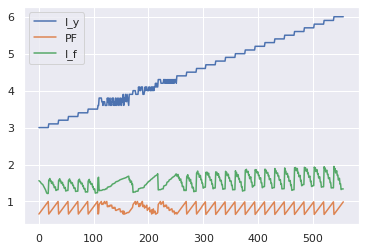

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
data.plot(y=['I_y', 'PF', 'I_f'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


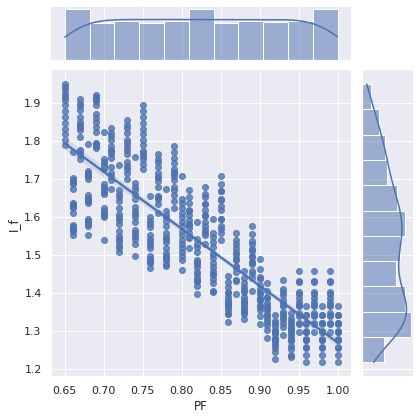

In [4]:
sns.jointplot('PF', 'I_f', data=data, kind='reg')